D1 ロジスティック回帰
57994 139667
18519 115332
acc 52.28 pre 45.23 rec 86.16 f1  59.32

D2　正規化/標準化　SVM　ホールドアウト/クロスバリデーション　正則化

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [2]:
#csvファイル読込。
df_csv = pd.read_csv("./ks-projects-201801.csv")


In [3]:
#ID name category main_category currency deadline goal launched pledged
#state backers country usd pledged usd_pledged_real usd_goal_real
#説明変数
#使えそう
#main_category, deadline(締切),
#launched(開始日), country, usd_goal_real(目標額USD？)
#main_categoryとusd_goalはセットで使えそう。(高価くても人気のジャンルとか、高価いといらないジャンルとか。)単体だと？
#deadlineとlaunchedはそのままじゃなくて期間にしたほうが都合よさそう。時間？日にち？
#countryは国によって成功率違うとかあるなら使えるか？
#name名前→ワード数

#使えなさそう
#ID, pledged(支援額), backers(支援者数), usd pledged(支援額USD), usd_pledged_real

#category, currency(通貨),  goal(目標額) を格下げ
#(main_category > category、countryとcurrncyはほぼ等価、USD/currency * goal =usd_goal_real)

#目的変数
#state

In [4]:
#Liveは省く
df = df_csv[df_csv["state"]!="live"]
#succesfullならTrue、それ以外がFalse
df["state"] = df["state"]=="successful"

X = df[['state','name',
        'main_category','category',
        'country', 'currency',
        'usd_goal_real','goal',
        'deadline','launched']].values
y = df["state"].values

C:\Users\M\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [6]:
#testセットは評価用なので触らない
#splitしたらnumpyarrayに変換されたのでもう一度dataframeに変換
df_X_train = pd.DataFrame(X_train)
df_y_train = pd.DataFrame(y_train)
df_X_test = pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)


In [40]:
pd.set_option('display.max_columns', 200)

In [7]:
#データ数。
display(df_X_train.count())
display(df_X_train.shape)
display(df_y_train.count())
display(df_y_train.shape)
display(df_X_test.count())
display(df_X_test.shape)
display(df_y_test.count())
display(df_y_test.shape)
#df_X_train

0    300689
1    300686
2    300689
3    300689
4    300689
5    300689
6    300689
7    300689
8    300689
9    300689
dtype: int64

(300689, 10)

0    300689
dtype: int64

(300689, 1)

0    75173
1    75172
2    75173
3    75173
4    75173
5    75173
6    75173
7    75173
8    75173
9    75173
dtype: int64

(75173, 10)

0    75173
dtype: int64

(75173, 1)

In [8]:
#欠損値の確認。
display(df_X_train.isnull().sum())

0    0
1    3
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [9]:
#欠損値のある行は削除。
df_X_train = df_X_train.dropna(how='any')
display(df_X_train.isnull().sum())

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [10]:

df_X_train_s = df_X_train.sample(n=100000,random_state=1234)
df_y_train_s = df_y_train.sample(n=100000,random_state=1234)
df_X_train_s

,0,1,2,3,4,5,6,7,8,9
63721,True,Pine Tar Baseball 1973: Dice Simulation of a V...,Games,Tabletop Games,US,USD,800,800,2015-08-22,2015-07-23 01:17:08
244290,False,ArePA George,Food,Food,US,USD,8000,8000,2016-11-05,2016-09-16 05:28:54
246398,True,Space Cadets: Away Missions,Games,Tabletop Games,US,USD,40000,40000,2015-02-20,2015-01-21 17:48:17
278946,False,The Toilet: A Northern Tale,Film & Video,Shorts,GB,GBP,4122.28,2500,2014-03-18,2014-02-16 18:28:19
11628,True,Cornell: Through My Eyes - A Summer College Ph...,Photography,Photography,US,USD,500,500,2014-04-25,2014-03-26 00:46:43
124289,False,Sassy's Soul Takeout and Small Batch Boutique,Food,Small Batch,US,USD,7500,7500,2017-01-01,2016-11-17 22:06:49
140099,True,"Kentucky Route Zero, a magic realist adventure...",Games,Video Games,US,USD,6500,6500,2011-02-06,2011-01-07 11:55:03
275138,True,Help Chez Franc make great hot dogs - Equip ou...,Food,Food,US,USD,37000,37000,2014-09-02,2014-08-03 21:19:21
82139,True,The 4th Meeting (A Drama with Comedic Elements),Film & Video,Narrative Film,US,USD,3500,3500,2013-03-27,2013-02-05 21:13:51
239641,False,2012 - 2013 Snowboarding film,Film & Video,Film & Video,US,USD,1500,1500,2012-12-05,2012-11-05 09:26:54


In [11]:
#LabelEncoderで変換。->state以外は値に意味が乗ってしまうと都合が悪い
le = LabelEncoder()
le = le.fit(df_X_train_s[0])
df_X_train_s[0] = le.transform(df_X_train_s[0])

#deadline - launchedで期間(日数)。
df_X_train_s['days_diff'] = (pd.to_datetime(df_X_train_s[8]) - pd.to_datetime(df_X_train_s[9])).dt.days
df_X_train_s = df_X_train_s.drop([8,9],axis=1)


In [12]:
#単語数を数える。スペースかタブか改行で区切る
def Count_Words(s):
    if type(s) is str:
        words = s.split()
        return len(words)
    else:
        return 0
#単語数の行を追加
df_X_train_s['words'] = df_X_train_s[1].apply(Count_Words)
#出てくる単語も取りたいけど。。。


df_X_train_s = df_X_train_s.drop(1,axis=1)
#df_X_train_s

In [13]:
#

#nameをWords_Countに分割する
#usdgoal,timediffを標準化する
#'main_category', 'category', 'currency', 'country'はどうする？増えすぎた。
#＞とりあえずcategoryとcurrencyは削除しとく goal

In [14]:

df_X_train_sd = pd.get_dummies(df_X_train_s,columns=[2, 3,4,5])
#df_X_train_sd = df_X_train_sd.drop([2,3],axis=1)

#display(df_X_train_sd)
display(df_X_train_sd.shape)

(100000, 216)

In [15]:
df_X_train_sd


,0,6,7,days_diff,words,2_Art,2_Comics,2_Crafts,2_Dance,2_Design,...,5_EUR,5_GBP,5_HKD,5_JPY,5_MXN,5_NOK,5_NZD,5_SEK,5_SGD,5_USD
63721,1,800,800,29,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
244290,0,8000,8000,49,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
246398,1,40000,40000,29,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
278946,0,4122.28,2500,29,5,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
11628,1,500,500,29,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
124289,0,7500,7500,44,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
140099,1,6500,6500,29,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
275138,1,37000,37000,29,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
82139,1,3500,3500,49,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
239641,0,1500,1500,29,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
#値の標準化
df_temp = df_X_train_sd[[6,7,'days_diff','words']]
df_X_train_sd_ = df_X_train_sd.drop([6,7,'days_diff','words'],axis=1)
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(df_temp)
df_std = pd.DataFrame(std_scaler.transform(df_temp),columns=df_temp.columns)

display(df_X_train_sd_.shape)
display(df_std.shape)
#df_std

(100000, 212)

(100000, 4)

In [17]:

df_X_train_sdr = df_X_train_sd_.reset_index(drop=True)


In [18]:
df_std_r = df_std.reset_index(drop=True)
#display(df_std_r)

In [19]:
df_X_train_std = pd.concat([df_X_train_sdr,df_std_r],axis=1)

display(df_X_train_std.shape)
df_X_train_std

(100000, 216)

,0,2_Art,2_Comics,2_Crafts,2_Dance,2_Design,2_Fashion,2_Film & Video,2_Food,2_Games,...,5_MXN,5_NOK,5_NZD,5_SEK,5_SGD,5_USD,6,7,days_diff,words
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,-0.036780,-0.040969,-0.324105,1.573800
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,-0.031310,-0.035220,1.236086,-1.339882
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,-0.007000,-0.009667,-0.324105,-0.611462
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,-0.034256,-0.039612,-0.324105,-0.247251
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.037008,-0.041209,-0.324105,1.573800
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,-0.031690,-0.035619,0.846038,0.481169
6,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,-0.032450,-0.036418,-0.324105,0.845379
7,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,-0.009279,-0.012063,-0.324105,2.302220
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,-0.034729,-0.038813,1.236086,0.845379
9,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,-0.036248,-0.040410,-0.324105,-0.247251


In [20]:
df_X_train_std_r = df_X_train_std.rename(columns={6:'usd_goal_real', 7:'goal'})
df_X_train_std_r

,0,2_Art,2_Comics,2_Crafts,2_Dance,2_Design,2_Fashion,2_Film & Video,2_Food,2_Games,...,5_MXN,5_NOK,5_NZD,5_SEK,5_SGD,5_USD,usd_goal_real,goal,days_diff,words
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,-0.036780,-0.040969,-0.324105,1.573800
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,-0.031310,-0.035220,1.236086,-1.339882
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,-0.007000,-0.009667,-0.324105,-0.611462
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,-0.034256,-0.039612,-0.324105,-0.247251
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.037008,-0.041209,-0.324105,1.573800
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,-0.031690,-0.035619,0.846038,0.481169
6,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,-0.032450,-0.036418,-0.324105,0.845379
7,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,-0.009279,-0.012063,-0.324105,2.302220
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,-0.034729,-0.038813,1.236086,0.845379
9,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,-0.036248,-0.040410,-0.324105,-0.247251


In [21]:
y = df_X_train_std_r[0].values
X = df_X_train_std_r.drop(0, axis=1)


In [22]:
#Lassoでパラメータを減らす。

In [23]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [24]:
# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [25]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,

In [26]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
X.columns[removed_idx]

Index(['2_Dance', '2_Games', '3_Ceramics', '3_Children's Books', '3_Comics',
       '3_Conceptual Art', '3_Crochet', '3_Design', '3_Experimental',
       '3_Fantasy', '3_Fashion', '3_Film & Video', '3_Food', '3_Gadgets',
       '3_Photography', '3_Pop', '3_Taxidermy', '3_Weaving', '3_Woodworking',
       '3_Workshops', '4_BE', '4_DK', '4_IE', '4_SE', '5_AUD', '5_CHF',
       '5_GBP', '5_JPY', '5_MXN', '5_NOK', '5_USD'],
      dtype='object')

In [27]:
used_idx = sfm.get_support()
X.columns[used_idx]

Index(['2_Art', '2_Comics', '2_Crafts', '2_Design', '2_Fashion',
       '2_Film & Video', '2_Food', '2_Journalism', '2_Music', '2_Photography',
       ...
       '5_DKK', '5_EUR', '5_HKD', '5_NZD', '5_SEK', '5_SGD', 'usd_goal_real',
       'goal', 'days_diff', 'words'],
      dtype='object', length=184)

In [28]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([4.32888762e-02, 1.76906865e-01, 6.43253551e-02, 0.00000000e+00,
       7.73265273e-05, 8.60399485e-02, 2.02255112e-03, 4.53744741e-02,
       0.00000000e+00, 2.47422323e-02, 1.21208319e-01, 7.31017121e-03,
       1.00399950e-02, 6.91588401e-02, 1.36056530e-01, 5.62956472e-02,
       1.21953970e-01, 9.41380525e-02, 1.19971049e-01, 9.98495583e-02,
       3.00044731e-02, 2.47384525e-01, 3.96199605e-02, 1.80542163e-01,
       9.67952231e-02, 2.16711823e-02, 1.61915734e-01, 5.05717751e-02,
       1.42296372e-01, 1.64507988e-02, 1.03008165e-01, 2.18888732e-01,
       1.38669185e-01, 0.00000000e+00, 0.00000000e+00, 8.29842307e-02,
       2.55762373e-01, 5.16386450e-02, 1.46891578e-01, 4.53863191e-02,
       5.96118036e-02, 0.00000000e+00, 4.25823509e-02, 0.00000000e+00,
       6.01697991e-03, 1.56842246e-01, 7.20889332e-02, 2.69076216e-02,
       0.00000000e+00, 7.93103020e-02, 1.72220718e-01, 3.06122677e-01,
       0.00000000e+00, 1.10014543e-01, 4.03617586e-02, 3.31708045e-02,
      

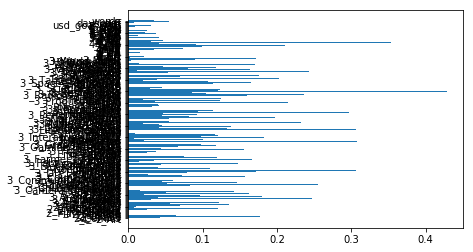

In [29]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=X.columns.values)
plt.show()

In [41]:
X_Lasso = X.drop(X.columns[removed_idx],axis=1)
display(X.shape)
display(X_Lasso.shape)
X_Lasso

(100000, 215)

(100000, 184)

,2_Art,2_Comics,2_Crafts,2_Design,2_Fashion,2_Film & Video,2_Food,2_Journalism,2_Music,2_Photography,2_Publishing,2_Technology,2_Theater,3_3D Printing,3_Academic,3_Accessories,3_Action,3_Animals,3_Animation,3_Anthologies,3_Apparel,3_Apps,3_Architecture,3_Art,3_Art Books,3_Audio,3_Bacon,3_Blues,3_Calendars,3_Camera Equipment,3_Candles,3_Childrenswear,3_Chiptune,3_Civic Design,3_Classical Music,3_Comedy,3_Comic Books,3_Community Gardens,3_Cookbooks,3_Country & Folk,3_Couture,3_Crafts,3_DIY,3_DIY Electronics,3_Dance,3_Digital Art,3_Documentary,3_Drama,3_Drinks,3_Electronic Music,3_Embroidery,3_Events,3_Fabrication Tools,3_Faith,3_Family,3_Farmer's Markets,3_Farms,3_Festivals,3_Fiction,3_Fine Art,3_Flight,3_Food Trucks,3_Footwear,3_Games,3_Gaming Hardware,3_Glass,3_Graphic Design,3_Graphic Novels,3_Hardware,3_Hip-Hop,3_Horror,3_Illustration,3_Immersive,3_Indie Rock,3_Installations,3_Interactive Design,3_Jazz,3_Jewelry,3_Journalism,3_Kids,3_Knitting,3_Latin,3_Letterpress,3_Literary Journals,3_Literary Spaces,3_Live Games,3_Makerspaces,3_Metal,3_Mixed Media,3_Mobile Games,3_Movie Theaters,3_Music,3_Music Videos,3_Musical,3_Narrative Film,3_Nature,3_Nonfiction,3_Painting,3_People,3_Performance Art,3_Performances,3_Periodicals,3_Pet Fashion,3_Photo,3_Photobooks,3_Places,3_Playing Cards,3_Plays,3_Poetry,3_Pottery,3_Print,3_Printing,3_Product Design,3_Public Art,3_Publishing,3_Punk,3_Puzzles,3_Quilts,3_R&B,3_Radio & Podcasts,3_Ready-to-wear,3_Residencies,3_Restaurants,3_Robots,3_Rock,3_Romance,3_Science Fiction,3_Sculpture,3_Shorts,3_Small Batch,3_Software,3_Sound,3_Space Exploration,3_Spaces,3_Stationery,3_Tabletop Games,3_Technology,3_Television,3_Textiles,3_Theater,3_Thrillers,3_Translations,3_Typography,3_Vegan,3_Video,3_Video Art,3_Video Games,3_Wearables,3_Web,3_Webcomics,3_Webseries,3_World Music,3_Young Adult,3_Zines,4_AT,4_AU,4_CA,4_CH,4_DE,4_ES,4_FR,4_GB,4_HK,4_IT,4_JP,4_LU,4_MX,"4_N,0""",4_NL,4_NO,4_NZ,4_SG,4_US,5_CAD,5_DKK,5_EUR,5_HKD,5_NZD,5_SEK,5_SGD,usd_goal_real,goal,days_diff,words
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.036780,-0.040969,-0.324105,1.573800
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.031310,-0.035220,1.236086,-1.339882
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.007000,-0.009667,-0.324105,-0.611462
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.034256,-0.039612,-0.324105,-0.247251
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.03700

In [31]:
#ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=1000, random_state=1234)
clf.fit(X_Lasso, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [32]:
y_prd = clf.predict(X_Lasso)
# 対数尤度
(- log_loss(y, y_prd))

-10.681879931124845

In [33]:
#正解率(TP+TN/TP+TN+FP+FN)
print(100 * accuracy_score(y, y_prd))
#精度(TP/TP+FP)
print(100 * precision_score(y, y_prd))
#検出率(TP/TP+FN)
print(100 * recall_score(y, y_prd))
#Fスコア
print(100 * f1_score(y, y_prd))

69.073
60.47909407665505
38.85391309214024
47.31256069098281


In [34]:
#day1
#acc 52.28 
#pre 45.23 
#rec 86.16 
#f1  59.32

In [35]:
#day2
#acc 66.19
#pre 62.57 
#rec 38.84 
#f1  47.93

In [ ]:
#アダーブースト

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

abclf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                  min_samples_split=2,
                                                  random_state=1234,
                                                  criterion="gini"),
                           n_estimators=10, 
                           random_state=1234)
abclf.fit(X_Lasso,y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=1234)

In [37]:
y_prd_ab = abclf.predict(X_Lasso)
# 対数尤度
(- log_loss(y, y_prd_ab))

-10.409373287203172

In [39]:
#正解率(TP+TN/TP+TN+FP+FN)
print(100 * accuracy_score(y, y_prd_ab))
#精度(TP/TP+FP)
print(100 * precision_score(y, y_prd_ab))
#検出率(TP/TP+FN)
print(100 * recall_score(y, y_prd_ab))
#Fスコア
print(100 * f1_score(y, y_prd_ab))

69.862
61.2809667673716
42.56694367497691
50.23776500891619


In [ ]:
%%time
parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5]} # ここを編集する
model = SVC()
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth":[i for i in range(1,6,1)],
              "base_estimator__min_samples_split":[i for i in range(2,6,1)],           
              "base_estimator__min_samples_leaf":[i for i in range(2,6,1)],
              "n_estimators": [1, 20]}

abclf = AdaBoostClassifier(DecisionTreeClassifier(random_state = 1234,
                                                  max_features = "auto",
                                                  max_depth = None))
# run grid search
gscv_abclf = GridSearchCV(abclf, param_grid=param_grid, scoring = 'roc_auc')
gscv_abclf.fit(X_Lasso,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__splitter': ['best', 'random'], 'base_estimator__max_depth': [1, 2, 3, 4, 5], 'base_estimator__min_samples_split': [2, 3, 4, 5], 'base_estimator__min_samples_leaf': [2, 3, 4, 5], 'n_estimators': [1, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [59]:
print(gscv_abclf.best_params_, gscv_abclf.best_score_)

{'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 4, 'base_estimator__splitter': 'best', 'n_estimators': 20} 0.7318680790846189


In [74]:
abclf2 = AdaBoostClassifier(DecisionTreeClassifier(random_state = 1234,
                                                  criterion = 'entropy',
                                                  max_depth = 5,
                                                  min_samples_leaf = 5,
                                                  min_samples_split= 4,
                                                  splitter = 'best'),
                           n_estimators = 20)

abclf2 = abclf2.fit(X_Lasso,y)                          

In [75]:
print(abclf2.score(X_Lasso,y))


0.70357


In [76]:
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(abclf2, out_file=dot_data,  
                #feature_names=iris.feature_names, 
                #class_names=iris.target_names, 
                #filled=True, rounded=True,  
                #special_characters=True
               ) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

NotFittedError: This AdaBoostClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.